In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
plt.style.use('ggplot') 
import calendar
import quandl
import pickle
from datetime import datetime, timedelta
import re  
import psycopg2
import sys
api_key = '764-Cog1Q3xa6Rns5pmj'
quandl.ApiConfig.api_key = api_key
import sqlalchemy
from sqlalchemy.sql import select, and_, or_, not_, desc, asc
from sqlalchemy import Table, Column, Integer, DateTime, String,Float, ForeignKey
from sqlalchemy.orm import sessionmaker

In [2]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

In [3]:
def connect(user, password, db, host='localhost', port=5432):
    '''Returns a connection and a metadata object'''
    # We connect with the help of the PostgreSQL URL
    url = 'postgresql+psycopg2://{}:{}@{}:{}/{}'
    url = url.format(user, password, host, port, db)

    # The return value of create_engine() is our connection object
    con = sqlalchemy.create_engine(url, client_encoding='utf8')

    # We then bind the connection to MetaData()
    meta = sqlalchemy.MetaData(bind=con)

    return con, meta

CREATE TABLES 

In [4]:
con, meta = connect('postgres', '', 'robotdb')
    
tickers = Table('Ticker', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('price', Float),
    Column('volume', Float),
    Column('screen', String, primary_key = True)    
)

macd = Table('Macd', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('ema12', Float),
    Column('ema_26', Float),
    Column('macd_line', Float),
    Column('signal_line', Float),
    Column('histogram', Float),
    Column('screen', Integer, primary_key=True)
)

boillinger = Table('Boillinger', meta,
                       Column('date', DateTime, primary_key=True),
                       Column('coin', String, primary_key=True),
                       Column('upper_band', Float),
                       Column('lower_band', Float),
                       Column('sma20', Float),
                       Column('height', Float),
                       Column('screen', Integer, primary_key=True)
                       )

ema = Table('Ema', meta,
                Column('date', DateTime, primary_key=True),
                Column('coin', String, primary_key=True),
                Column('ema5', Float),
                Column('ema20', Float),
                Column('ema5_theta', Float),
                Column('ema20_theta', Float),
                Column('screen', Integer, primary_key=True)
                )

long_positions = Table('Long', meta,
                       Column('id_position', Integer, primary_key=True),
                       Column('coin', String, primary_key=True),
                       Column('strategy', String),
                       Column('size_position', Float),
                       Column('date_ask', DateTime),
                       Column('ask', Float),
                       Column('date_settlement', DateTime),
                       Column('settlement', Float),
                       Column('take_profit', Float),
                       Column('stop_loss', Float),
                       Column('exit_date', DateTime),
                       Column('exit_price', Float),
                       Column('log_return', Float),
                       Column('source', String),
                       Column('status', String)
                       )


mkt_trend = Table('Market_trend', meta,
                  Column('coin', String, primary_key=True),
                  Column('date', DateTime, primary_key=True),
                  Column('screen', Integer, primary_key=True),
                  Column('dif_current', Float),
                  Column('dif_base', Float),
                  Column('d_dif', Float),
                  Column('theta_current', Float),
                  Column('theta_base', Float),
                  Column('d_theta', Float),
                  Column('vote', Integer)
                  )


rsi = Table('Rsi', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('rsi', Float),
    Column('screen', Integer, primary_key=True)
)

balances = Table('Balance', meta,
                 Column('date', DateTime, primary_key=True),
                 Column('coin', String, primary_key=True),
                 Column('size_position', Float)
                 )


years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

In [5]:
def get_macds(coin = None, date = '2019-12-31', screen = 1):
    if coin:
        s = select([macd])\
            .where(and_(macd.c.coin == coin, macd.c.date <= date, macd.c.screen==screen))\
            .order_by(desc(macd.c.date))
    else:
         s = select([macd])\
            .where(and_(macd.c.date <= date, macd.c.screen==screen))\
            .order_by(desc(macd.c.date))
            
    rows = con.execute(s)
    macd_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not macd_df.empty:
        macd_df.columns = rows.keys()
    return macd_df

def get_tickers(coin = None, date = '2019-12-31', screen = 1):
    if coin:
        s = select([tickers])\
            .where(and_(tickers.c.coin == coin, tickers.c.date <= date, tickers.c.screen == screen))\
            .order_by(
            desc(tickers.c.date))
    else:
        s = select([tickers])\
            .where(and_(tickers.c.date <= date, tickers.c.screen == screen))\
            .order_by(
            desc(tickers.c.date))
    rows = con.execute(s)
    tickers_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not tickers_df.empty:
        tickers_df.columns = rows.keys()
    return tickers_df

def get_positions(coin=None, status='closed', date='2019-12-31'):
    if coin:
        s = select([long_positions]) \
            .where(and_(long_positions.c.coin == coin,
                        long_positions.c.date_ask <= date,
                        long_positions.c.status == status))\
            .order_by(desc(long_positions.c.date_ask))
    else:
        s = select([long_positions]) \
            .where(and_(long_positions.c.date_ask <= date,
                        long_positions.c.status == status))\
            .order_by(desc(long_positions.c.date_ask))
    rows = con.execute(s)
    long_positions_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not long_positions_df.empty:
        long_positions_df.columns = rows.keys()
    return long_positions_df

def get_emas(coin=None, date='2019-12-31', screen=1):
    if coin:
        s = select([ema])\
            .where(and_(ema.c.coin == coin, ema.c.date <= date, ema.c.screen == screen))\
            .order_by(ema.c.date.desc())
    else:
        s = select([ema])\
            .where(and_(ema.c.date <= date, ema.c.screen == screen))\
            .order_by(ema.c.date.desc())
    rows = con.execute(s)
    ema_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not ema_df.empty:
        ema_df.columns = rows.keys()
    return ema_df

def get_mkt_trend(coin=None, date='2019-12-31', screen=1):
    if coin:
        s = select([mkt_trend]).\
            where(and_(mkt_trend.c.coin == coin, mkt_trend.c.date <= date, mkt_trend.c.screen == screen)).\
            order_by(desc(mkt_trend.c.date))
    else:
        s = select([mkt_trend]).\
            where(and_(mkt_trend.c.date <= date, mkt_trend.c.screen == screen)).\
            order_by(desc(mkt_trend.c.date))
    rows = con.execute(s)
    mkt_trend_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    mkt_trend_df.columns = rows.keys()
    return mkt_trend_df

def get_balances(date, coin=None):
    if coin:
        s = select([balances]) \
            .where(and_(balances.c.coin == coin,
                        balances.c.date <= date))\
            .order_by(desc(balances.c.date))
    else:
        s = select([balances]) \
            .where(and_(balances.c.date <= date))\
            .order_by(desc(balances.c.date))
    rows = con.execute(s)
    balances_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not balances_df.empty:
        balances_df.columns = rows.keys()
    return balances_df

def get_rsis(coin=None, date='2019-12-31', screen=1):
    if coin:
        s = select([rsi]) \
            .where(and_(rsi.c.coin == coin,
                        rsi.c.date <= date,
                       rsi.c.screen == screen))\
            .order_by(desc(rsi.c.date))
    else:
        s = select([rsi]) \
            .where(and_(rsi.c.date <= date,
                        rsi.c.screen == screen
                       ))\
            .order_by(desc(rsi.c.date))
    rows = con.execute(s)
    rsi_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not rsi_df.empty:
        rsi_df.columns = rows.keys()
    return rsi_df

In [6]:
def get_max_growth(tickers_filtered, base_price):
    max_growth = 0
    min_growth = 0
    for i, r in tickers_filtered.iterrows():
        g = np.log(r.price/base_price)
        max_growth = g if g > max_growth else max_growth
        min_growth = g if g < min_growth else min_growth
    return max_growth, min_growth


def get_max_min(mkt_trend_df):
    tickers_df_two = get_tickers()
    tickers_df_one = get_tickers(screen=0)
    for c in tickers_df_two.coin.unique():
        tickers_df_two_c = tickers_df_two[tickers_df_two['coin'] == c]
        tickers_df_one_c = tickers_df_one[tickers_df_one['coin'] == c]
        print(c)
        # 6 * 4h = 24h
        delta_t = 2
        for index in range(len(tickers_df_two_c)):
            base_date = tickers_df_two_c.iloc[index].date
            base_price = tickers_df_two_c.iloc[index].price
            if index >= (len(tickers_df_two_c)-delta_t):
                break
            last_date = tickers_df_two_c.iloc[(index+delta_t)].date
            t = tickers_df_one_c[(tickers_df_one_c['date'] >= base_date) & (tickers_df_one_c['date'] < last_date)]
            max_growth, min_growth = get_max_growth(t, base_price)
            tickers_df_two.loc[(tickers_df_two['date'] == base_date) & 
                               (tickers_df_two['coin'] == c), 'max_growth'] = max_growth
            tickers_df_two.loc[(tickers_df_two['date'] == base_date) & 
                               (tickers_df_two['coin'] == c), 'min_growth'] = min_growth
    
    tickers_df_two = tickers_df_two.dropna()
    return tickers_df_two

In [7]:
def manipulate_mkt_data():
    mkt_trend_df = get_mkt_trend()
    tickers_df_two = get_max_min(mkt_trend_df)
    macds_df = get_macds()
    tickers_df = pd.merge(tickers_df_two, macds_df, how='inner', left_on=['date', 'coin'], right_on=['date', 'coin'])
    tickers_df['ema_dif'] = np.log(tickers_df['price']/tickers_df['ema12'])
    df = pd.merge(mkt_trend_df, tickers_df, how='inner', left_on=['date', 'coin'], right_on=['date', 'coin'])
    df.loc[(1 > df['ema_dif']) & (df['ema_dif'] > -0.1), 'ema_sign'] = 1
    df.loc[(1 <= df['ema_dif']) | (df['ema_dif'] <= -0.1), 'ema_sign'] = 0
    rsis_df = get_rsis()
    df = pd.merge(df, rsis_df, how='inner', left_on=['date', 'coin'], right_on=['date', 'coin'])
    return df
    
df = manipulate_mkt_data()

USDT_BTC


In [8]:
f_df = df.drop(['signal_line', 'histogram', 'screen_x', 'screen_y', 'screen', 'vote', 'price', 'ema_26',
               'macd_line', 'ema12'], axis = 1)
f_df.loc[f_df['max_growth'] >= 0.1, 'growth_sign'] = 1
f_df.loc[f_df['max_growth'] < 0.1, 'growth_sign'] = 0
f_df.loc[f_df['min_growth'] <= -0.1, 'reduce_sign'] = 1
f_df.loc[f_df['min_growth'] > -0.1, 'reduce_sign'] = 0

/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [65]:
full_data_set = f_df[['coin', 'date', 'dif_base', 'dif_current', 'd_dif', 'theta_base', 'theta_current',
                      'd_theta', 'ema_dif', 'rsi','min_growth', 'max_growth', 'reduce_sign',
                      'max_growth', 'growth_sign']]

In [66]:
model = full_data_set.sort_values(['date'])
x_features = ['date', 'coin', 'dif_base', 'dif_current', 'd_dif', 'rsi',
              'theta_base', 'theta_current', 'd_theta', 'ema_dif']
y_features = ['growth_sign']

In [67]:
df_model = model[x_features + y_features]
def get_strength_index():
    tickers_df_two = get_tickers()
    for c in tickers_df_two.coin.unique():
        tickers_df_two_c = tickers_df_two[tickers_df_two['coin'] == c]
        print(c)
        # 6 * 4h = 24h
        delta_t = 1
        si_np = [np.nan]
        for index in range(len(tickers_df_two_c)):
            base_price = tickers_df_two_c.iloc[index].price
            if index >= (len(tickers_df_two_c)-delta_t):
                break
            current_price = tickers_df_two_c.iloc[index+1].price
            volume = tickers_df_two_c.iloc[index+1].volume
            si = (current_price - base_price) * volume
            si_np.append(si)
        tickers_df_two_c['strength'] = si_np
    return tickers_df_two_c.dropna()

df_model = pd.merge(df_model, get_strength_index(), how='inner',
                    left_on=['date', 'coin'], right_on=['date', 'coin'])
df_model['ema_s'] = df_model.drop(['date', 'coin'], axis=1).strength.\
                    ewm(span=2, min_periods=2, adjust=True, ignore_na=False).mean()

USDT_BTC


In [68]:
df_model = df_model[['dif_base', 'dif_current', 'd_dif', 'theta_base', 'theta_current', 'rsi',
                     'strength','d_theta', 'ema_dif', 'growth_sign']].dropna()
df_model.head()

,dif_base,dif_current,d_dif,theta_base,theta_current,rsi,strength,d_theta,ema_dif,growth_sign
0,0.008354,0.008392,0.004599,0.346777,-0.287716,60.539884,2.093483e+08,-1.829686,0.000454,0.0
1,0.008853,0.008354,-0.056411,-0.287716,0.760201,57.623211,1.332995e+08,-3.642190,0.010214,0.0
2,0.007897,0.008853,0.121092,0.760201,0.590882,51.480427,5.142551e+06,-0.222730,0.009692,0.0
3,0.007297,0.007897,0.082179,0.590882,0.033830,47.818230,2.007921e+07,-0.942747,0.010452,0.0
4,0.007407,0.007297,-0.014862,0.033830,0.138108,39.150200,4.283235e+07,3.082404,0.014720,0.0


In [69]:
x_features = ['dif_base', 'dif_current', 'd_dif', 'theta_base',  'theta_current', 'd_theta', 'rsi','strength','d_theta', 'ema_dif']
y_features = ['growth_sign']

In [113]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


X = df_model[x_features]
y = df_model[y_features].growth_sign.values

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

unbalance = df_model['growth_sign'].sum() / df_model['growth_sign'].count()
weight = np.array([1/unbalance if i == 1 else 1 for i in Y_train])

Random Forest With Unbalanced Dataset

In [114]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train,Y_train, sample_weight=weight)
Y_predict = rf.predict(X_test)

In [115]:
print(confusion_matrix(Y_test,Y_predict))
print(classification_report(Y_test,Y_predict))

[[311   0]
 [  8   0]]
             precision    recall  f1-score   support

        0.0       0.97      1.00      0.99       311
        1.0       0.00      0.00      0.00         8

avg / total       0.95      0.97      0.96       319



/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [116]:
FP, TP, thresholds = roc_curve(Y_test,Y_predict)
roc_auc = auc(FP, TP)
print (roc_auc)

0.5


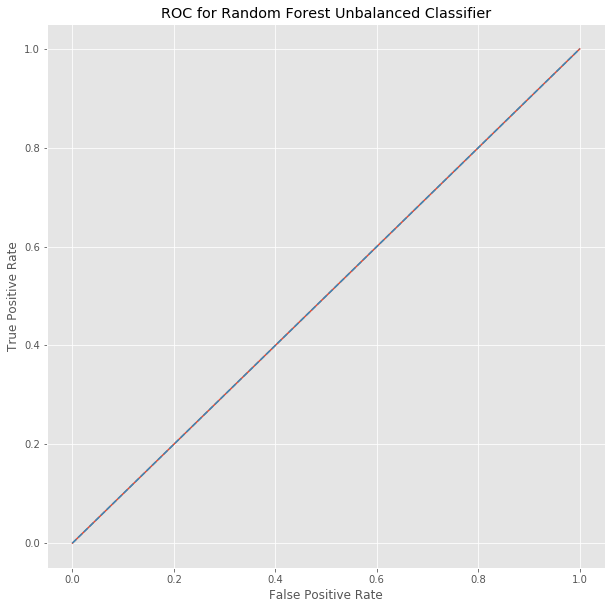

In [117]:
plt.plot(FP, TP, label='AUC = %0.2f'% roc_auc)
plt.title('ROC for Random Forest Unbalanced Classifier')
plt.plot([0,1],[0,1],'--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Random Forest with Balanced Dataset (SMOTE)

In [119]:
oversampler = SMOTE(random_state=42)
X_train_os,Y_train_os=oversampler.fit_sample(X_train,Y_train)
rf_os = RandomForestClassifier(random_state=42)
rf_os.fit(X_train_os,Y_train_os)
Y_predict_os = rf_os.predict(X_test)

In [120]:
print(confusion_matrix(Y_test,Y_predict_os))
print(classification_report(Y_test,Y_predict_os))

[[302   9]
 [  6   2]]
             precision    recall  f1-score   support

        0.0       0.98      0.97      0.98       311
        1.0       0.18      0.25      0.21         8

avg / total       0.96      0.95      0.96       319



In [121]:
FP, TP, thresholds = roc_curve(Y_test,Y_predict_os)
roc_auc = auc(FP, TP)
print (roc_auc)

0.610530546624


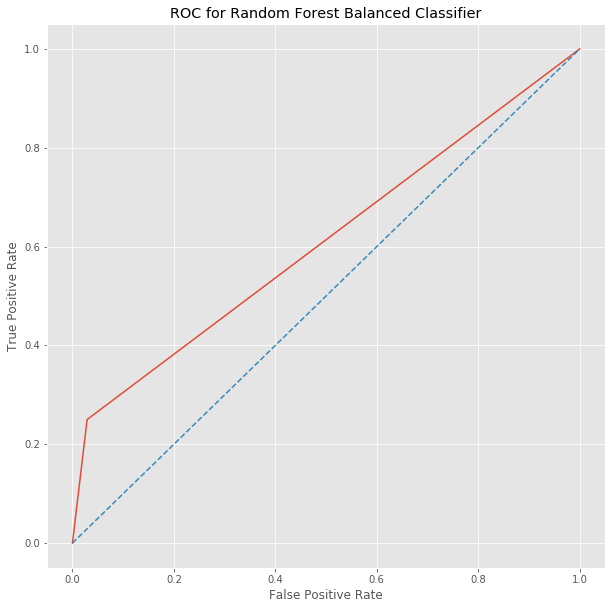

In [122]:
plt.plot(FP, TP, label='AUC = %0.2f'% roc_auc)
plt.title('ROC for Random Forest Balanced Classifier')
plt.plot([0,1],[0,1],'--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [163]:
from sklearn.model_selection import cross_val_score, KFold

param_grid = {'max_depth': np.arange(1, 12), 'min_samples_leaf':np.arange(1, 12), 
              'max_features': np.arange(1, len(x_features))}
X = df_model[x_features]
y = df_model[y_features].growth_sign.values

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
oversampler = SMOTE(random_state=42)
X_train_os, Y_train_os = oversampler.fit_sample(X_train,Y_train)

rf_os = RandomForestClassifier(random_state=42)
rf_os.fit(X_train_os,Y_train_os)
Y_predict_os = rf_os.predict(X_test)

knn = KNeighborsClassifier()
rf_os_cv = GridSearchCV(rf_os, param_grid, cv=5, scoring='roc_auc')
rf_os_cv.fit(X_train_os, Y_train_os)

print(rf_os_cv.best_params_)
print(rf_os_cv.best_score_)

{'max_depth': 11, 'max_features': 6, 'min_samples_leaf': 2}
0.993453416548


In [164]:
Y_predict = rf_os_cv.predict(X_test)

In [167]:
print(confusion_matrix(Y_test,Y_predict_os))
print(classification_report(Y_test,Y_predict_os))

[[302   9]
 [  6   2]]
             precision    recall  f1-score   support

        0.0       0.98      0.97      0.98       311
        1.0       0.18      0.25      0.21         8

avg / total       0.96      0.95      0.96       319



In [165]:
FP, TP, thresholds = roc_curve(Y_test,Y_predict)
roc_auc = auc(FP, TP)
print (roc_auc)

0.663384244373


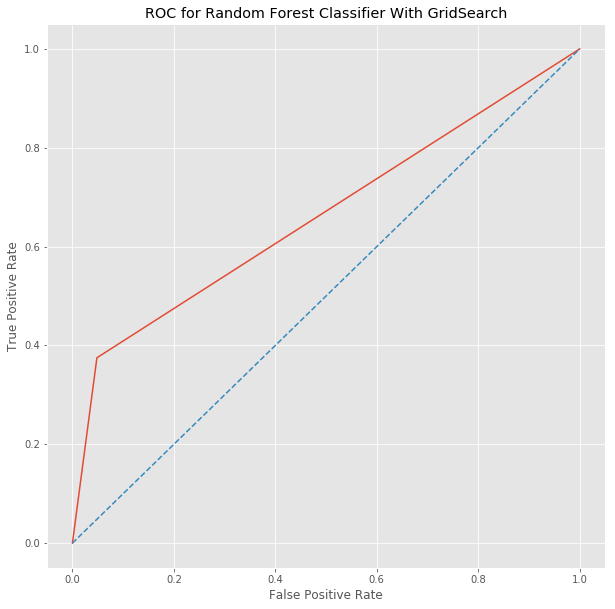

In [166]:
plt.plot(FP, TP, label='AUC = %0.2f'% roc_auc)
plt.title('ROC for Random Forest Classifier With GridSearch')
plt.plot([0,1],[0,1],'--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

KNN Classifier With Balanced Dataset (SMOTE)

In [143]:
from sklearn.neighbors import KNeighborsClassifier

X = df_model[x_features]
y = df_model[y_features].growth_sign.values

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

oversampler = SMOTE(random_state=42)
X_train_os, Y_train_os = oversampler.fit_sample(X_train,Y_train)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_os, Y_train_os)
Y_predict = knn.predict(X_test)

In [144]:
print(confusion_matrix(Y_test,Y_predict))
print(classification_report(Y_test,Y_predict))

[[212  99]
 [  5   3]]
             precision    recall  f1-score   support

        0.0       0.98      0.68      0.80       311
        1.0       0.03      0.38      0.05         8

avg / total       0.95      0.67      0.78       319



In [145]:
FP, TP, thresholds = roc_curve(Y_test,Y_predict)
roc_auc = auc(FP, TP)
print (roc_auc)

0.528336012862


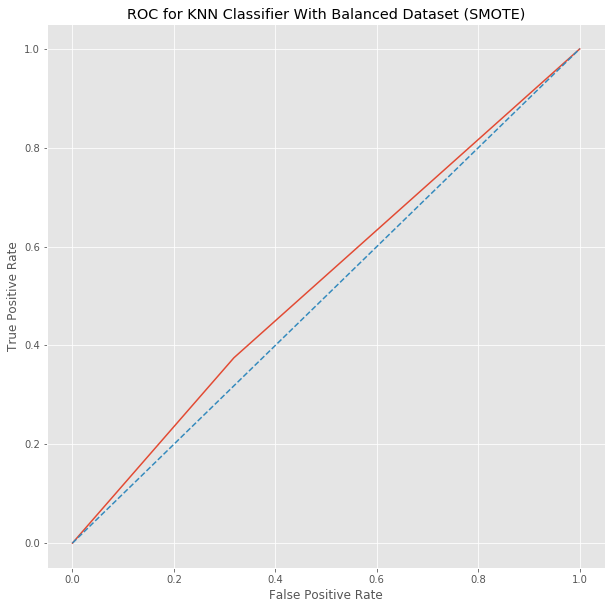

In [146]:
plt.plot(FP, TP, label='AUC = %0.2f'% roc_auc)
plt.title('ROC for KNN Classifier With Balanced Dataset (SMOTE)')
plt.plot([0,1],[0,1],'--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

KNN Classifier With Balanced Dataset and GridSearchCV

In [147]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


param_grid = {'n_neighbors': np.arange(1, 50)}
X = df_model[x_features]
y = df_model[y_features].growth_sign.values

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

oversampler = SMOTE(random_state=42)
X_train_os, Y_train_os = oversampler.fit_sample(X_train,Y_train)

knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc')
knn_cv.fit(X_train_os, Y_train_os)

print(knn_cv.best_params_)
print(knn_cv.best_score_)

{'n_neighbors': 38}
0.794396345992


In [148]:
Y_predict = knn_cv.predict(X_test)

In [149]:
FP, TP, thresholds = roc_curve(Y_test,Y_predict)
roc_auc = auc(FP, TP)
print (roc_auc)

0.531752411576


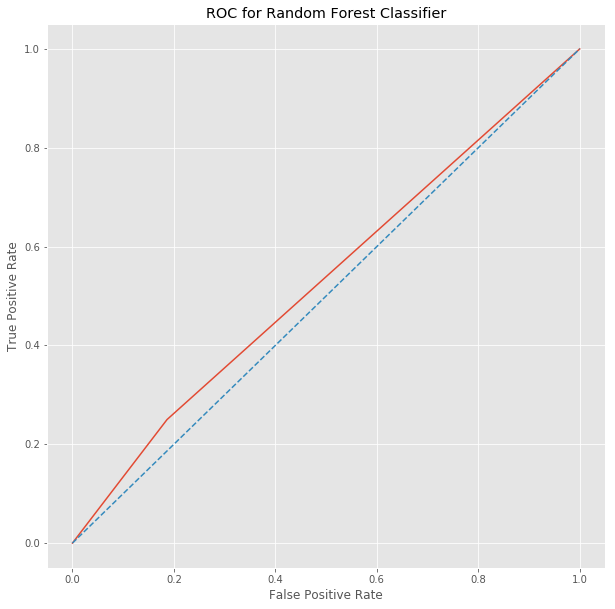

In [150]:
plt.plot(FP, TP, label='AUC = %0.2f'% roc_auc)
plt.title('ROC for Random Forest Classifier')
plt.plot([0,1],[0,1],'--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()